### ZTF Light Curve Plotting

Let's try plotting some light curves from that low luminosity sample to recreate [Das et al. 2025](https://arxiv.org/abs/2506.20068).

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alerce.core import Alerce
from astropy.stats import sigma_clipped_stats
from tqdm import tqdm
import time
import json

In [2]:
df = pd.read_csv('data/ZTF_alerce_alerts.csv')
df

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF18aaszvfn,93,2072,58248.310775,59391.288310,False,False,40,-0.063799,0.865591,...,59391.288310,83.960486,215.782862,50.220817,0.000044,0.000022,NaN,NaN,NaN,correction_0.0.1
1,ZTF18abjndhh,66,397,58324.166528,58486.489676,False,False,11,0.377247,NaN,...,58486.489676,162.323148,173.179280,62.432761,0.000074,0.000027,NaN,NaN,NaN,corr_bulk_0.0.1
2,ZTF18abzrgim,32,75,58388.269190,58494.133542,False,False,26,0.336168,NaN,...,58494.133542,105.864352,346.885593,23.005797,0.000030,0.000021,NaN,NaN,NaN,corr_bulk_0.0.1
3,ZTF19aadnxnl,482,1220,58502.489664,58901.430382,False,False,109,0.255573,NaN,...,58901.430382,398.940718,203.811186,44.766284,0.000041,0.000025,NaN,NaN,NaN,corr_bulk_0.0.1
4,ZTF19aailepg,83,377,58514.464630,58661.200752,False,False,66,0.216761,NaN,...,58661.200752,146.736123,169.467734,30.156520,0.000039,0.000040,NaN,NaN,NaN,corr_bulk_0.0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,ZTF24aafqzur,55,943,60355.520359,60471.292118,True,False,36,NaN,NaN,...,60471.292118,115.771759,216.488345,-2.392265,0.008317,0.008309,NaN,NaN,NaN,24.5.1
104,ZTF24aagupsf,183,3955,60374.513438,60473.367002,False,False,56,NaN,NaN,...,60473.367002,89.952558,247.672867,44.511143,0.010341,0.007374,NaN,NaN,NaN,24.5.1
105,ZTF24aajxppf,113,2120,60416.479329,60555.171528,True,False,81,NaN,NaN,...,60555.171528,136.799097,269.590144,9.681528,0.038562,0.038013,NaN,NaN,NaN,24.5.2a6
106,ZTF24aaplfjd,174,2001,60460.465995,60581.460706,True,False,63,NaN,NaN,...,60581.460706,120.994711,14.505587,30.706595,0.098861,0.085000,NaN,NaN,NaN,24.5.2a6


In [3]:
## Using a lot of Viraj's code from LSST CCA Summer School

# Color config for filters
colors = {1: "green", 2: "red"}
labels = {1: 'g', 2: 'r'}
markers = {1: 'o', 2: 's'}
sizes = {1: 30, 2: 60}


def query_all_detections(oid, client, page_size=10000):
    """Fetch all detection rows for a given oid from ALeRCE."""
    all_dets = []
    page = 1
    while True:
        dets = client.query_detections(
            oid, format='pandas', page=page, page_size=page_size
        )
        if dets.empty:
            break
        all_dets.append(dets)
        page += 1
    return pd.concat(all_dets, ignore_index=True) if all_dets else pd.DataFrame()


def query_all_nondetections(oid, client, page_size=10000):
    """Fetch all non-detection rows for a given oid from ALeRCE."""
    all_nd = []
    page = 1
    while True:
        nd = client.query_non_detections(
            oid, format='pandas', page=page, page_size=page_size
        )
        if nd.empty:
            break
        all_nd.append(nd)
        page += 1
    return pd.concat(all_nd, ignore_index=True) if all_nd else pd.DataFrame()

def plotStamps(oid, lc_det, client):
    # Find first detection with a valid stamp
    if "has_stamp" not in lc_det.columns or lc_det["has_stamp"].sum() == 0:
        print(f"⚠️ No stamp available for {oid}")
        return

    try:
        candid = lc_det.loc[lc_det.has_stamp].sort_values("mjd").candid.iloc[0]
        stamps = client.get_stamps(oid, candid, format='HDUList')
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
    except Exception as e:
        print(f"❌ Failed to fetch stamps for {oid}: {e}")
        return

    # Plot the cutouts
    fig, ax = plt.subplots(ncols=3, figsize=(8, 4))
    titles = ["Science", "Reference", "Difference"]
    images = [science, ref, difference]

    for i in range(3):
        img = np.log1p(images[i])  # log scale with log1p for stability
        _, med, std = sigma_clipped_stats(img, sigma=3.0)
        ax[i].imshow(img, cmap='viridis', origin='lower')
        ax[i].set_title(titles[i])
        ax[i].axis("off")

    fig.suptitle(f"{oid}, candid: {candid}", fontsize=12, y=0.9)
    plt.tight_layout()
    plt.show()

def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize=(9, 5))

    # Loop over whatever filters are actually present
    for fid in sorted(SN_det.fid.dropna().unique()):
        color = colors.get(fid, "black")
        label = labels.get(fid, f"fid={fid}")
        marker = markers.get(fid, "o")
        size = sizes.get(fid, 40)

        # --- Detections ---
        mask_det = (SN_det.fid == fid) & SN_det.magpsf.notna()
        if mask_det.any():
            ax.errorbar(
                SN_det.loc[mask_det, "mjd"],
                SN_det.loc[mask_det, "magpsf"],
                yerr=SN_det.loc[mask_det, "sigmapsf"],
                c=color, label=label,
                marker=marker, linestyle='none'
            )

        # --- Non-detections (limits) ---
        mask_nondet = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > 0)
        if mask_nondet.any():
            ax.scatter(
                SN_nondet.loc[mask_nondet, "mjd"],
                SN_nondet.loc[mask_nondet, "diffmaglim"],
                c=color, alpha=0.5, marker='v',
                label=f"lim.mag. {label}", s=size
            )

    ax.set_title(oid, fontsize=16)
    ax.set_xlabel("MJD", fontsize=14)
    ax.set_ylabel("Apparent magnitude", fontsize=14)

    # Flip y-axis so brighter = up
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.legend()
    ax.grid(True, alpha=0.4)

    plt.tight_layout()
    plt.show()

def get_lc_data(oid, client, doLC=False, doStamps=False):
    results = {"oid": oid}

    try:
        lc_det = client.query_detections(oid, format='pandas').sort_values("mjd")
        results["lc_det"] = lc_det
    except Exception as e:
        print(f"⚠️ Could not fetch detections for {oid}: {e}")
        lc_det = pd.DataFrame()

    try:
        lc_nondet = client.query_non_detections(oid, format='pandas').sort_values("mjd")
        results["lc_nondet"] = lc_nondet
    except Exception as e:
        print(f"⚠️ Could not fetch non-detections for {oid}: {e}")
        lc_nondet = pd.DataFrame()

    if doLC and not lc_det.empty and not lc_nondet.empty:
        plotLC(oid, lc_det, lc_nondet)

    if doStamps and not lc_det.empty:
        plotStamps(oid, lc_det, client)

    return results

Let's plot **ZTF22abtspsw/SN 2022aagp** which had the steepest observed drop of $>3.5$ mag.

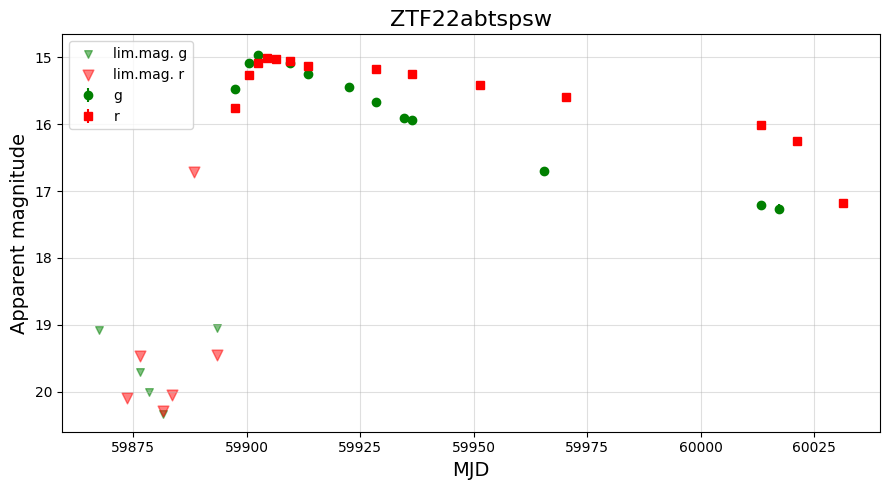

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


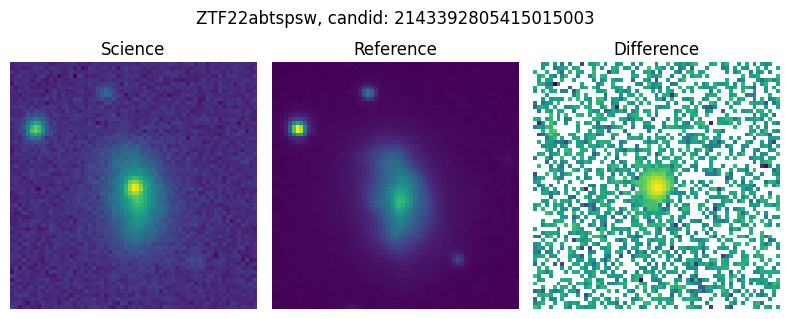

In [4]:
alerce = Alerce()
_ = get_lc_data('ZTF22abtspsw', alerce, doLC=True, doStamps=True)

Ok I think the reason we are missing the tail is because ALeRCE only does non-detections before the first detection. So we might need to query forced photometry? **Look towards end of notebook for my attempt at plotting light curves from ZTF forced photometry**

In [5]:
df[df['oid'] == "ZTF22abtspsw"]

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
77,ZTF22abtspsw,39,1007,59897.5,60031.25,False,False,26,-0.049599,NaN,...,60031.261644,133.868843,137.674607,7.205662,0.000024,0.000026,NaN,NaN,NaN,1.1.6


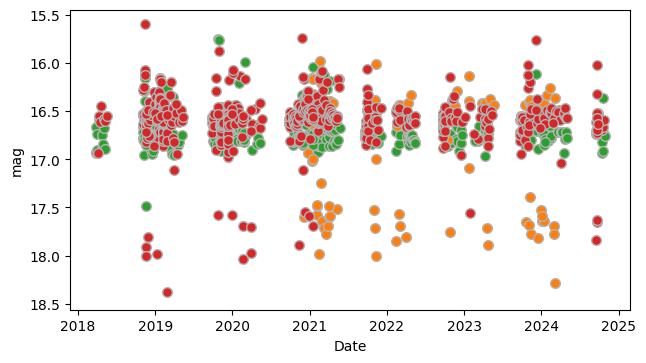

In [6]:
from ztfquery import lightcurve
lcq = lightcurve.LCQuery.from_position(137.674607, +7.205662, 5)
lcq.show()

  0%|          | 0/10 [00:00<?, ?it/s]

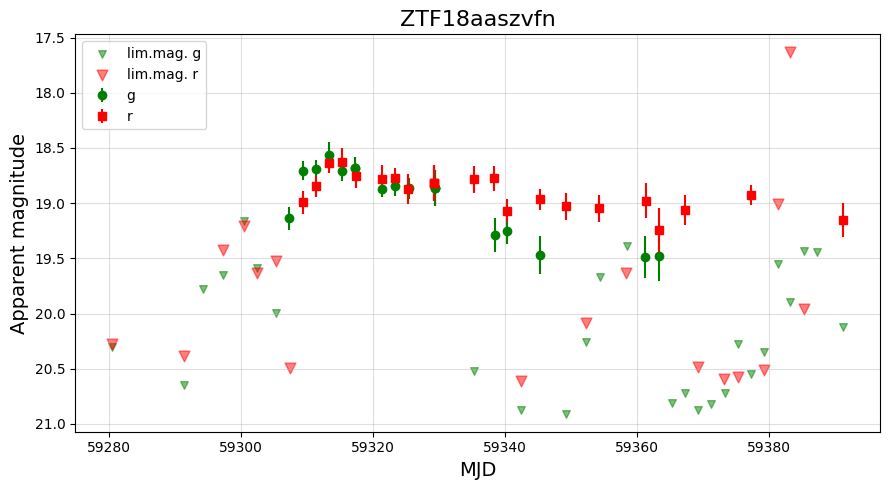

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


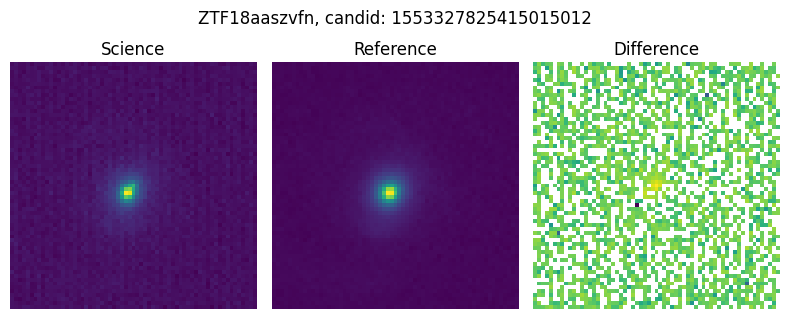

 10%|█         | 1/10 [00:02<00:18,  2.10s/it]

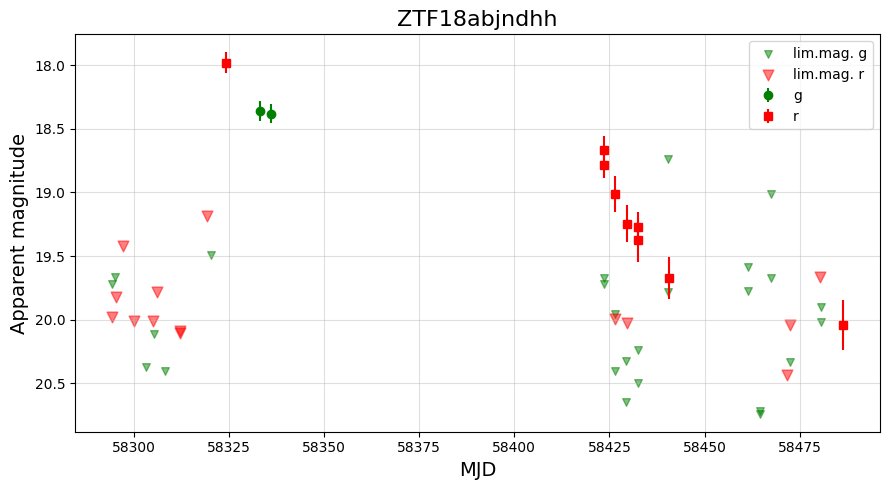

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


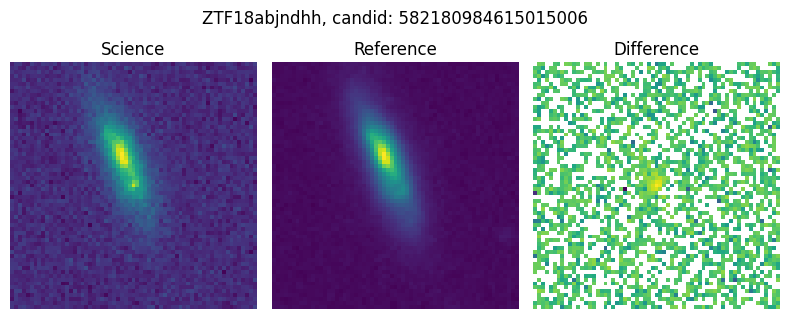

 20%|██        | 2/10 [00:05<00:24,  3.05s/it]

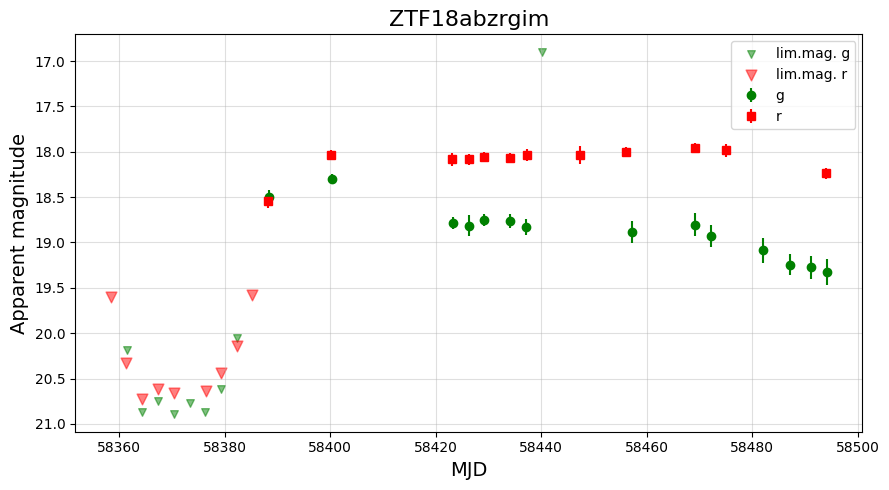

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


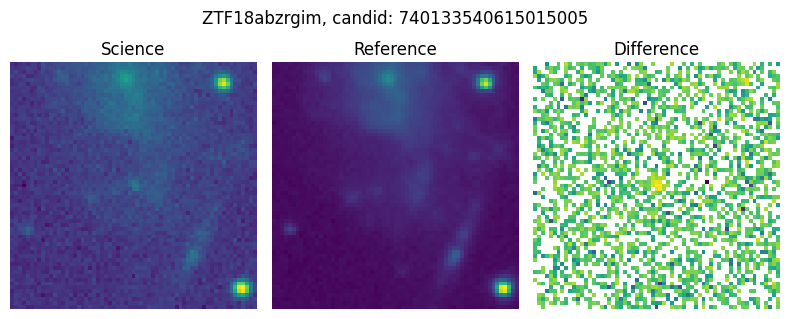

 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

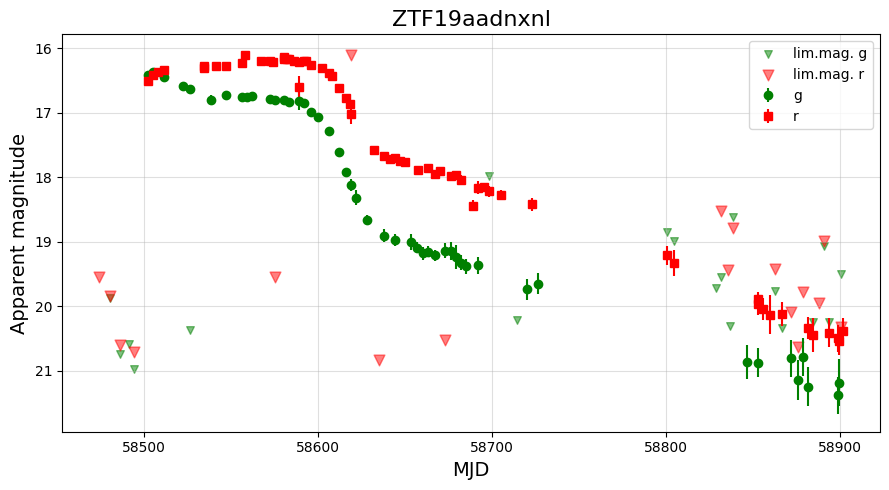

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


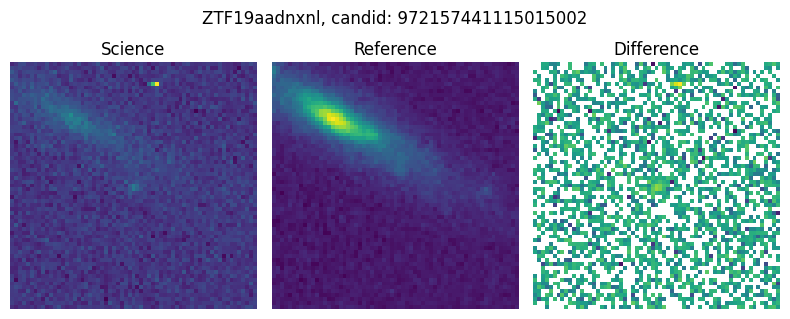

 40%|████      | 4/10 [00:10<00:15,  2.54s/it]

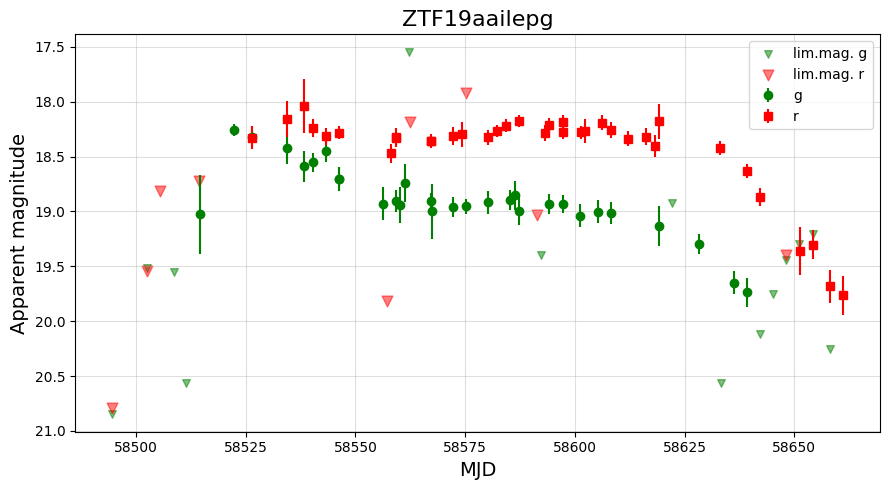

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


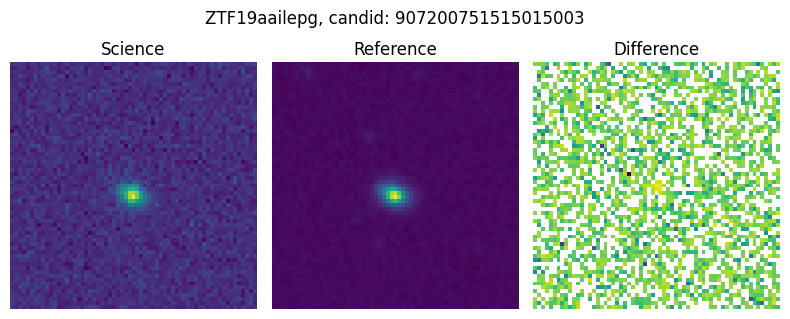

 50%|█████     | 5/10 [00:12<00:11,  2.37s/it]

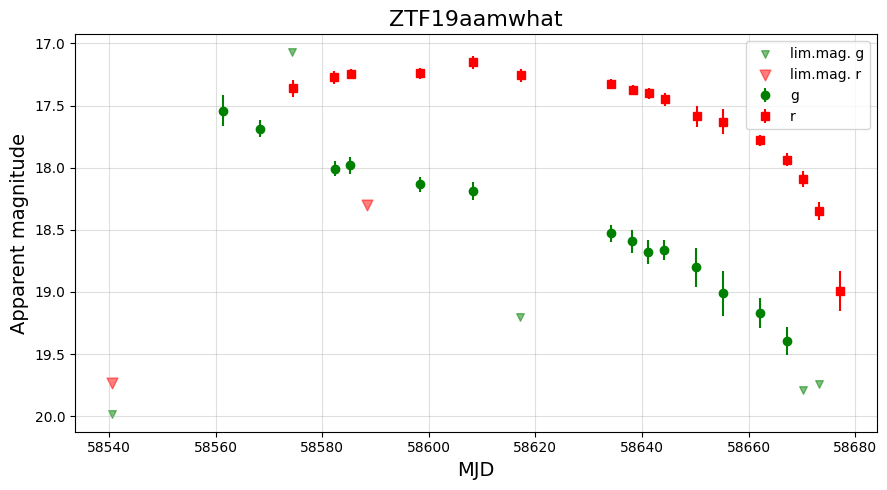

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


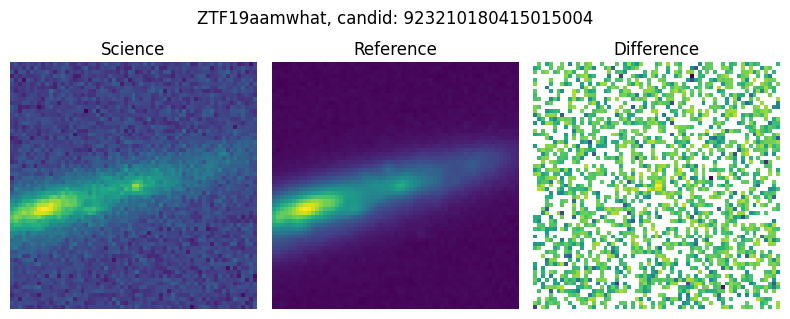

 60%|██████    | 6/10 [00:14<00:09,  2.34s/it]

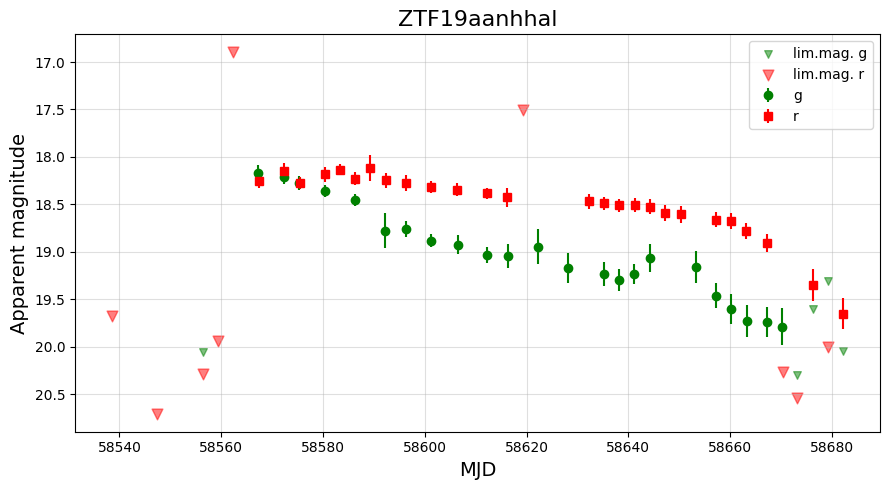

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


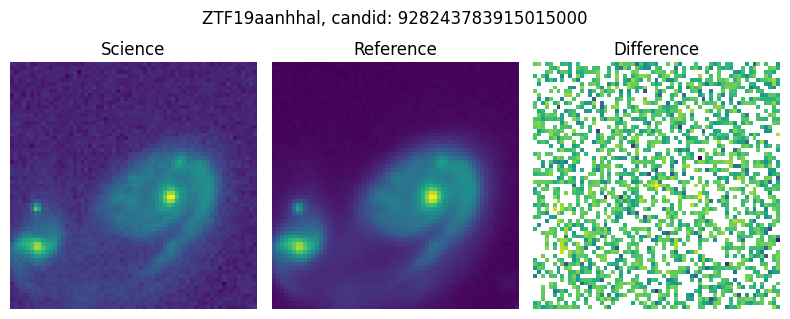

 70%|███████   | 7/10 [00:16<00:06,  2.29s/it]

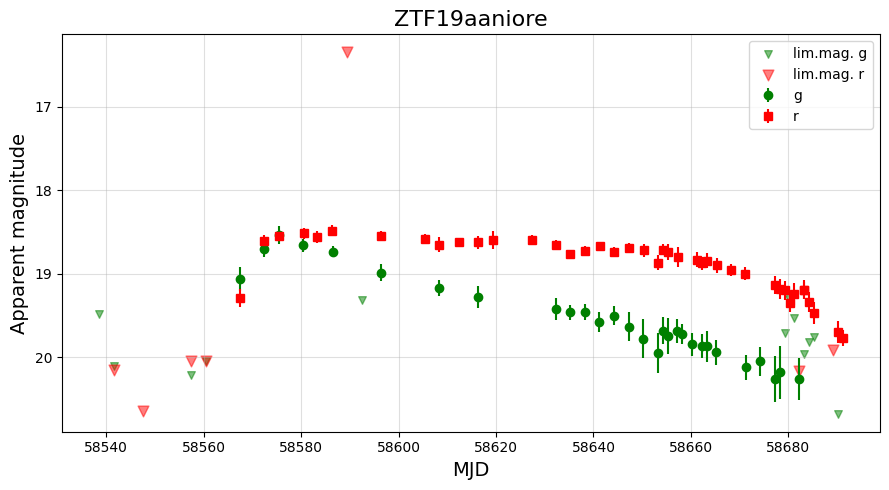

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


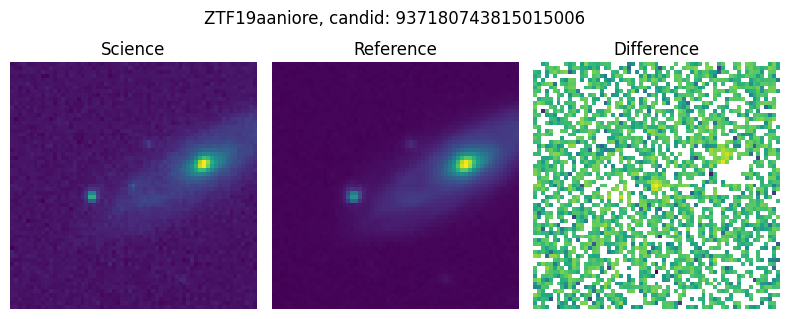

 80%|████████  | 8/10 [00:19<00:04,  2.36s/it]

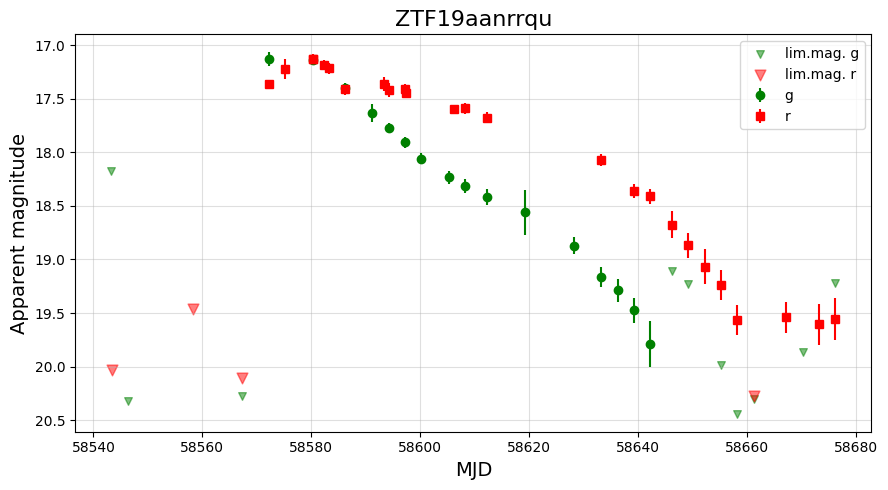

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


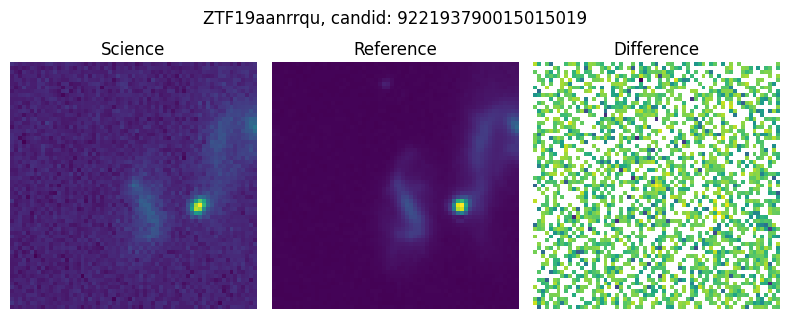

 90%|█████████ | 9/10 [00:21<00:02,  2.27s/it]

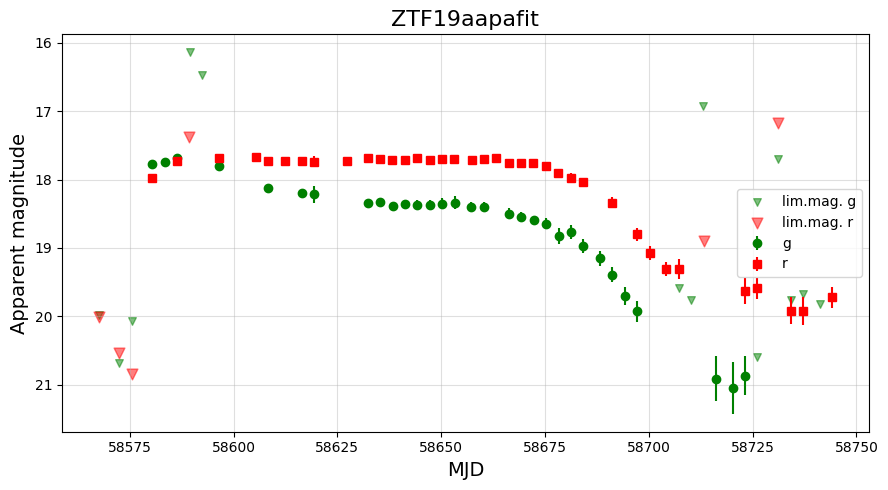

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/2841198616.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


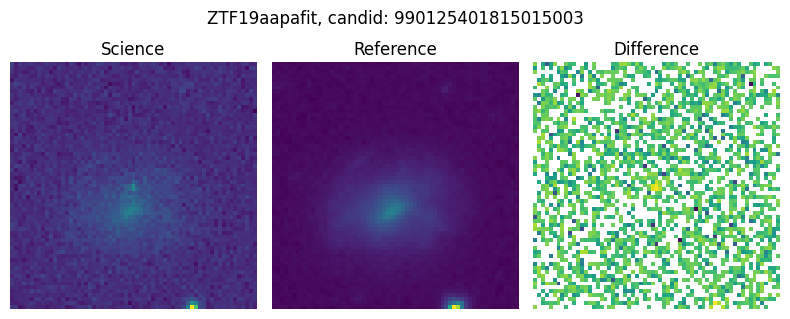

100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


In [7]:
for ind in tqdm(range(len(df[:10]))):
    _ = get_lc_data(
        df.iloc[ind]['oid'],
        alerce,
        doLC=True,
        doStamps=True
    )

Found ZTF forced photometry data from Das paper. They are found in `data/Das_forced_photometry_files`.

In [8]:
def get_ztf_forcedphot_lc(filename):
    """
    Parse a ZTF forced photometry .dat file into times, fluxes, errors, and filters.
    Returns a dictionary grouped by filter.
    """
    # Load into pandas, skipping header lines beginning with '#'
    df = pd.read_csv(
        filename,
        comment='#',
        delim_whitespace=True,
        header=0,
        skiprows=1
    )
    df.columns = df.columns.str.replace(",", "").str.strip()

    # Convert JD to MJD
    df["mjd"] = df["jd"] - 2400000.5

    # Compute magnitudes and errors
    # mag = zpdiff - 2.5*log10(flux), valid only if flux > 0
    df["mag"] = np.nan
    df["mag_err"] = np.nan
    good = df["forcediffimflux"] > 0
    df.loc[good, "mag"] = df.loc[good, "zpdiff"] - 2.5*np.log10(df.loc[good, "forcediffimflux"])
    df.loc[good, "mag_err"] = 1.0857 * df.loc[good, "forcediffimfluxunc"] / df.loc[good, "forcediffimflux"]

    # Organize output
    resdict = {}
    for filt in df["filter"].unique():
        mask = df["filter"] == filt
        resdict[filt] = {
            "mjd": df.loc[mask, "mjd"].values,
            "flux": df.loc[mask, "forcediffimflux"].values,
            "flux_err": df.loc[mask, "forcediffimfluxunc"].values,
            "mag": df.loc[mask, "mag"].values,
            "mag_err": df.loc[mask, "mag_err"].values,
            "limiting_mag": df.loc[mask, "diffmaglim"].values,
        }
    return resdict

def plot_ztf_lc(resdict, oid="ZTF source"):
    
    fig, ax = plt.subplots(figsize=(9,5))

    colors = {"ZTF_g":"green","ZTF_r":"red","ZTF_i":"orange"}
    markers = {"ZTF_g":"o","ZTF_r":"s","ZTF_i":"D"}

    for filt, data in resdict.items():
        color = colors.get(filt,"black")

        # --- Detections ---
        mask_det = ~np.isnan(data["mag"])
        if np.any(mask_det):
            ax.errorbar(
                data["mjd"][mask_det],
                data["mag"][mask_det],
                yerr=data["mag_err"][mask_det],
                fmt="o", color=color, label=filt,
                marker = markers.get(filt, "o")
            )

        # --- Non-detections (limits) ---
        mask_nondet = np.isnan(data["mag"]) & (data["limiting_mag"] > 0)
        if np.any(mask_nondet):
            ax.scatter(
                data["mjd"][mask_nondet],
                data["limiting_mag"][mask_nondet],
                marker="v", alpha=0.5, color=color,
                label=f"lim. mag {filt}"
            )

    ax.set_title(f"ZTF Light Curve: {oid}", fontsize=16)
    ax.set_xlabel("MJD", fontsize=14)
    ax.set_ylabel("Apparent magnitude", fontsize=14)
    ax.set_ylim(ax.get_ylim()[::-1])  # brighter = up
    ax.set_ylim(21, 14)
    ax.set_xlim(59850, 60075)
    ax.legend()
    ax.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

In [9]:
res = get_ztf_forcedphot_lc('data/Das_forced_photometry_files/ZTF22abtspsw_fps.dat')

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/3526242174.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [10]:
res['ZTF_g']['mag']

array([22.85734535, 23.45856465,         nan, 21.22216288,         nan,
               nan,         nan, 21.81058378, 23.08556659, 21.98516871,
       23.99736669, 26.26361595,         nan, 22.04213289,         nan,
               nan,         nan,         nan, 22.67315166,         nan,
               nan, 22.64961189,         nan, 24.31600303,         nan,
       22.57149037,         nan, 24.24054772,         nan, 20.39246671,
               nan,         nan,         nan,         nan, 24.00754768,
       21.8396672 , 19.52498361,         nan, 21.19488589, 22.51827784,
               nan,         nan, 20.72780026, 23.83940003,         nan,
       18.4253068 ,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, 21.799843  ,         nan,
       24.10783351,         nan,         nan,         nan, 22.59032382,
       23.61474882,         nan,         nan,         nan,         nan,
               nan,         nan, 22.40287796,         nan,      

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_13800/3526242174.py:54: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


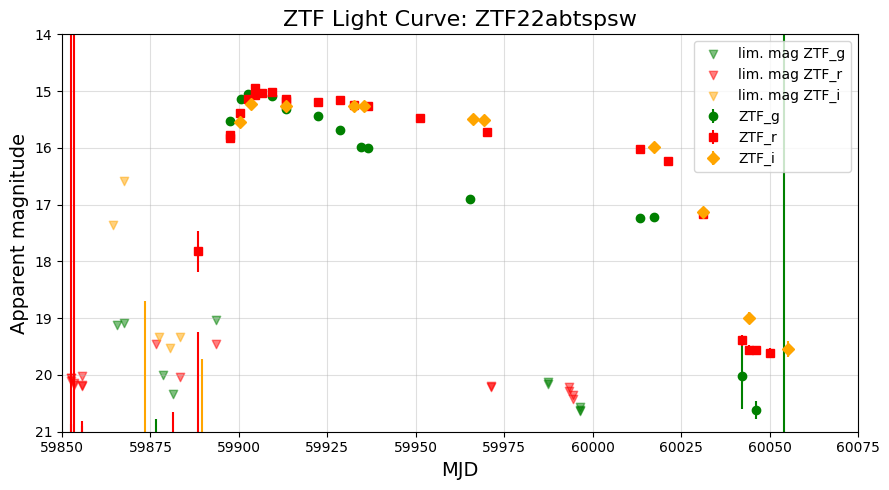

In [11]:
plot_ztf_lc(res, oid="ZTF22abtspsw")

Now how about the IR data...

In [16]:
def get_wise_lc(filename):
    f = open(filename, 'r')
    jfile = json.load(f)
    outmags = [jfile[j] for j in jfile.keys()]
    times = np.array([o['mjd'] for o in outmags])
    fluxes = np.array([o['psfflux'] for o in outmags])
    fluxerrs = np.array([o['psfflux_unc'] for o in outmags])
    bands = np.array([o['bandid'] for o in outmags])
    zps = np.array([o['zp'] for o in outmags])
    zpflux = np.zeros(len(bands))
    #create zero point fluxes in Jy as provided in the WISE official release supplements
    for i in range(len(bands)):
        if bands[i] == 1:
            zpflux[i] = 309
        else:
            zpflux[i] = 172
    zps = np.array([o['zp'] for o in outmags])
    mjy_fluxes = zpflux * 10**(-zps/2.5) * fluxes * 1e3
    mjy_fluxerrs = zpflux * 10**(-zps/2.5) * fluxerrs * 1e3
    snrs = fluxes/fluxerrs
    
    b1filt = (bands == 1)
    b2filt = (bands == 2)
    
    b1_times = times[b1filt]
    b1_fluxes = mjy_fluxes[b1filt]
    b1_fluxerrs = mjy_fluxerrs[b1filt]
    
    b2_times = times[b2filt]
    b2_fluxes = mjy_fluxes[b2filt]
    b2_fluxerrs = mjy_fluxerrs[b2filt]    
    
    resdict = {'b1_times': b1_times, 'b1_fluxes': b1_fluxes, 'b1_fluxerrs': b1_fluxerrs,
               'b2_times': b2_times, 'b2_fluxes': b2_fluxes, 'b2_fluxerrs': b2_fluxerrs}
    return resdict

In [ ]:
get_wise_lc('data/ztf_snii_lcs_WISE/lightcurve_ZTF22abtspsw_r137.67_d7.21.diff.json')

FileNotFoundError: [Errno 2] No such file or directory: 'data/ztf_snii_lcs_WISE/ZTF22abtspsw_wise_lc.json'